In [1]:
import numpy as np
from scipy.ndimage import map_coordinates
from typing import Tuple, List
import cv2
import matplotlib.pyplot as plt
import time
import math

- In the above function  the small `u,v` represents the coordinates in the tangential projected viewport `uv` and the capital `U,V` represents the coordinates in the ERP image.

- We orient the viewport as if it were a tangent to a sphere at the north pole, but at a distance `f` from the center of the sphere.

- In the panorama-to-plane conversion process, a key-step involves calculating the focal length, `f` which is derived from the field of view `FOV`, and the width of the output image, `W` . The focal length is crucial because it determines the perspective scale of the image priojection from spherical to a flat plane. 

- To find the focal length we use an empirical formula that takes the half-width of the output image and divides it by the tangent of half the field of view (converted to radians).

- Once we have the Cartesian coordinates, we pass them to the map_to_sphere function along with the yaw and the pitch angles converted to radians. This function will map our Cartesian coordinates `(x, y, z)` onto the sphere, returning the spherical coordinates `(theta, phi)`. This mapping is akin to projecting the flat image onto a sphere, and we’ll use these spherical coordinates to sample the correct pixels from the original panoramic image. 

- This would be an essential step in converting a panorama into a standard view because it allows us to consider the perspective and distortion that comes from viewing a spherical image in a rectangular frame `(the infamous ERP)`. 

- The resulting angles theta and phi will be used to find the corresponding points on the original panoramic image that we need to sample to construct our output image

- Intuitively, we know that the point height will be proportional to the theta  and the width will be proportional to phi  thus we have `U = phi x erp_width/ 2*pi`, `V = theta x erp_height / pi`


In [2]:
# Function to draw bounding box on the image
def draw_bbox(image, bbox, color=(255, 0, 0), thickness=2):
    x, y, w, h = map(int, bbox)
    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), color, thickness)
    return image_with_bbox

def is_box_near_edges(bbox_coords, frame_width, frame_height, threshold=20):
    x, y, w, h = bbox_coords
    
    near_top = y < threshold
    near_bottom = (y + h) > (frame_height - threshold)
    near_left = x < threshold
    near_right = (x + w) > (frame_width - threshold)

    if near_top or near_bottom or near_left or near_right:
        return {
            'near_top': near_top,
            'near_bottom': near_bottom,
            'near_left': near_left,
            'near_right': near_right
        }
    return False

left


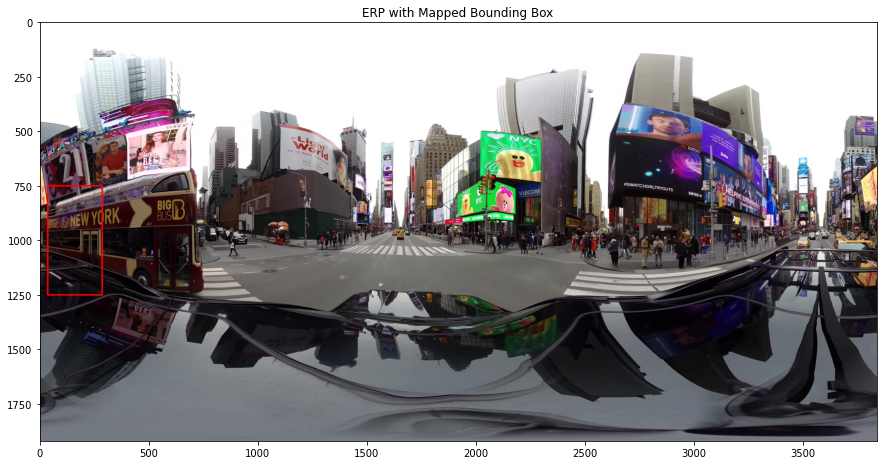

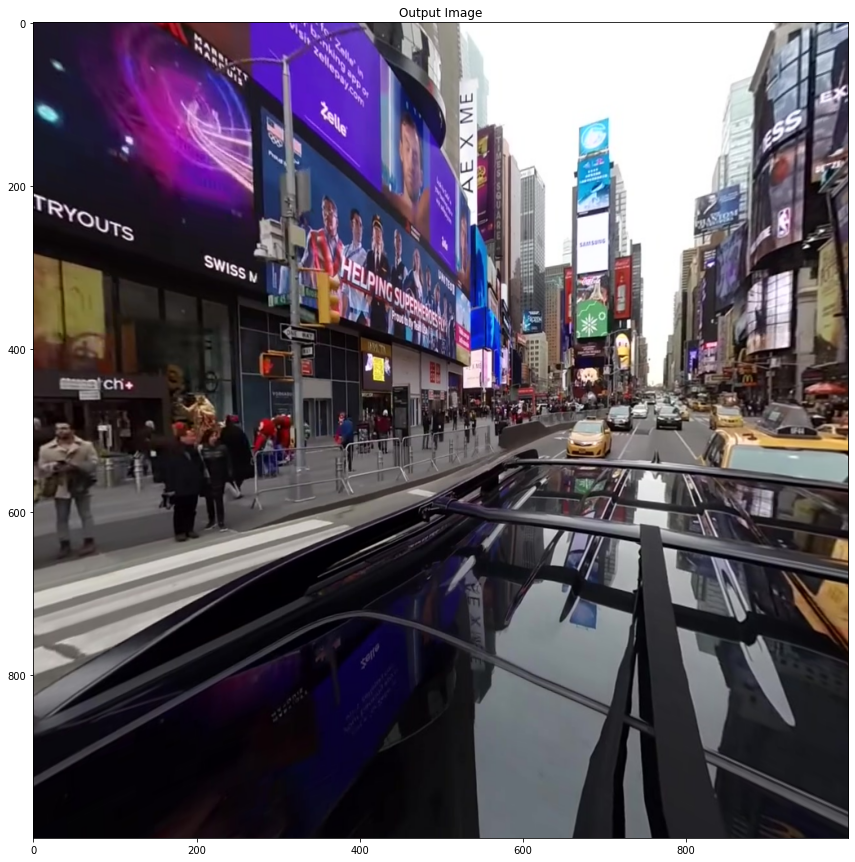

In [70]:
def clip_box(box: list, img_shape, margin=0):
    H, W = img_shape
    x1, y1, w, h = box
    x2 = x1 + w
    y2 = y1 + h

    x1 = min(max(0, x1), W - margin)
    x2 = min(max(margin, x2), W)
    y1 = min(max(0, y1), H - margin)
    y2 = min(max(margin, y2), H)

    w = max(margin, x2 - x1)
    h = max(margin, y2 - y1)
    print(x, y, w, h)
    return [x1, y1, w, h]

class TangentialProjector:
    def __init__(self, erp_img: np.ndarray, bbox_coords: Tuple[int, int, int, int], FOV: float = 90, search_area_factor = 2, output_size: Tuple[int, int] = 1000, direction='centre'):
        self.FOV = FOV
        self.output_size = (output_size, output_size)
        self.erp = erp_img
        self.erp_height, self.erp_width, _ = self.erp.shape
        self.search_area_factor = search_area_factor
        self.bbox_coords = bbox_coords
        self.yaw_radian, self.pitch_radian = self._calculate_projection_params(direction=direction)
         
    def _calculate_bbox_center(self) -> Tuple[int, int]:
        x, y, w, h = self.bbox_coords
        cx = x + w / 2
        cy = y + h / 2
        return int(cx), int(cy)

    def _calculate_projection_params(self, direction='centre') -> Tuple[float, float]:
        cx, cy = self._calculate_bbox_center()
        x, y, w, h = self.bbox_coords
        print(direction)

        adjustment_factor = (w*h/ self.erp_width) * 180 

        if direction == 'right':
             rotate_x = 360 * (cx / self.erp_width) - 180 + adjustment_factor
        elif direction == 'left':
             rotate_x = 360 * (cx / self.erp_width) + adjustment_factor
        else:
            rotate_x = 360 * (cx / self.erp_width) - 180

        rotate_y = (cy / self.erp_height) * 180
        return np.radians(rotate_x), np.radians(rotate_y)
        

    def _map_to_sphere(self, x: np.ndarray, y: np.ndarray, z: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        norm = np.sqrt(x ** 2 + y ** 2 + z ** 2)
        theta = np.arccos(z / norm)
        phi = np.arctan2(y, x)

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)

        sin_pitch = np.sin(self.pitch_radian)
        cos_pitch = np.cos(self.pitch_radian)

        theta_prime = np.arccos(sin_theta * sin_phi * sin_pitch + cos_theta * cos_pitch)
        phi_prime = np.arctan2(sin_theta * sin_phi * cos_pitch - cos_theta * sin_pitch, sin_theta * cos_phi)
        phi_prime = (phi_prime + self.yaw_radian) % (2 * np.pi)

        return theta_prime, phi_prime

    def _interpolate_color(self, coords: np.ndarray, method: str = 'bilinear') -> np.ndarray:
        order = {'nearest': 0, 'bilinear': 1, 'bicubic': 3}.get(method, 1)
        channels = [map_coordinates(self.erp[:, :, c], coords, order=order, mode='reflect') for c in range(3)]
        return np.stack(channels, axis=-1)

    def project(self) -> np.ndarray:
        W, H = self.output_size
        f = (0.5 * W) / np.tan(np.radians(self.FOV) / 2)

        u, v = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
        x = u - W / 2
        y = H / 2 - v
        z = f

        theta, phi = self._map_to_sphere(x, y, z)

        U = phi * self.erp_width / (2 * np.pi)
        V = theta * self.erp_height / np.pi

        U, V = U.flatten(), V.flatten()
        coords = np.vstack((V, U))

        colors = self._interpolate_color(coords)
        output_image = colors.reshape((H, W, 3)).astype('uint8')

        return output_image

    def _plane_to_sphere(self, u: np.ndarray, v: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        W, H = self.output_size
        f = (0.5 * W) / np.tan(np.radians(self.FOV) / 2)
        x = u - W / 2
        y = H / 2 - v
        z = f
        return self._map_to_sphere(x, y, z)

    def _sphere_to_panorama(self, theta: np.ndarray, phi: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        U = phi * self.erp_width / (2 * np.pi)
        V = theta * self.erp_height / np.pi
        return U, V

    def inverse_project(self, plane_coords: np.ndarray) -> np.ndarray:
        u, v = plane_coords.T
        theta, phi = self._plane_to_sphere(u, v)
        U, V = self._sphere_to_panorama(theta, phi)
        return np.vstack((U, V)).T
    

# Usage example
bbox_coords = [35, 750,  250, 500]
erp_image_path = '/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/0018/image/000580.jpg'
erp_image = cv2.cvtColor(cv2.imread(erp_image_path), cv2.COLOR_BGR2RGB)
height, width, _ = erp_image.shape
erp_with_bbox = draw_bbox(erp_image, bbox_coords, thickness=5)

direction='centre'
proximity_dict = is_box_near_edges(bbox_coords, width, height, threshold=50)
if proximity_dict:
    if proximity_dict['near_left']:
            direction = 'left'
    elif proximity_dict['near_right']:
            direction = 'right'


# Create the PanoramaProjector object
projector = TangentialProjector(erp_image, bbox_coords, FOV=90, direction=direction)

start = time.time()
# Generate the plane image from the panorama
output_image = projector.project()

# Example bounding box coordinates detected in the Tangential Projection Crop
x, y, w, h = [100, 200, 500, 200]  # Example coordinates (x, y, w, h)

# u_coords, v_coords = np.meshgrid(np.arange(x, x + w + 1), np.arange(y, y + h + 1))
# plane_coords = np.vstack((u_coords.ravel(), v_coords.ravel())).T
corners = np.array([
    [x, y],        # top-left
    [x + w, y],    # top-right
    [x, y + h],    # bottom-left
    [x + w, y + h] # bottom-right
])

# Perform inverse projection for all points in the bounding box
erp_remapped = erp_image.copy()
pano_coords = projector.inverse_project(corners)

pano_coords_min = np.min(pano_coords, axis=0)
pano_coords_max = np.max(pano_coords, axis=0)

wrap_case=False
if pano_coords_max[0] - pano_coords_min[0] > width//2:
    wrap_case = True

if wrap_case:
    box_1 = [0, pano_coords_min[1], pano_coords_min[0], pano_coords_max[1] - pano_coords_min[1]]
    box_2 = [pano_coords_max[0], pano_coords_max[1], width - pano_coords_max[0], pano_coords_min[1] - pano_coords_max[1]]
    erp_remapped_with_bbox = draw_bbox(erp_remapped, clip_box(box_1, (height, width)), thickness=10)
    erp_remapped_with_bbox = draw_bbox(erp_remapped_with_bbox, box_2, thickness=10)



# Plot the ERP image
# plt.figure(figsize=(15, 15))
# plt.imshow(erp_image)
# plt.scatter(pano_coords[:, 0], pano_coords[:, 1], color='red', s=100, marker='x')
# plt.title('ERP with Corners Marked')
# plt.show()



# # Convert coordinates to integers

# # Find the min and max coordinates for the bounding box in the ERP


# print(pano_coords_max)
# threshold = 10
# wrap_case = False
# if pano_coords_min[0] < threshold and pano_coords_max[0] > (width - threshold):
#     wrap_case = True


# if wrap_case:
#     predictions_on_erp_1 = [threshold - pano_coords_min[0], pano_coords_min[1], pano_coords_min[0] , pano_coords_max[1] - pano_coords_min[1]] 
#     predictions_on_erp_2 = [pano_coords_max[0], pano_coords_min[1], width - pano_coords_max[0], pano_coords_max[1] - pano_coords_min[1]] 
#     print(predictions_on_erp_1, predictions_on_erp_2)
#     erp_remapped_with_bbox = draw_bbox(erp_remapped, predictions_on_erp_1, thickness=10)
#     erp_remapped_with_bbox = draw_bbox(erp_remapped_with_bbox, predictions_on_erp_2, thickness=10)



# # predictions_on_erp = [pano_coords_min[0], pano_coords_min[1], pano_coords_max[0] - pano_coords_min[0], pano_coords_max[1] - pano_coords_min[1]]
# # erp_remapped_with_bbox = draw_bbox(erp_image, predictions_on_erp, thickness=10)
# end = time.time()
# # print(f"The projection and its inverse took {end-start:.2f} seconds to complete.")

plt.figure(figsize=(15, 15))
plt.imshow(erp_with_bbox)
plt.title('ERP with Mapped Bounding Box')
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(output_image)
plt.title('Output Image')
plt.show()


# plt.figure(figsize=(15, 15))
# plt.imshow(draw_bbox(output_image, [x, y, w, h], thickness=2))
# plt.title('Output Image')
# plt.show()

# plt.figure(figsize=(15, 15))
# plt.imshow(erp_remapped_with_bbox)
# plt.title('Output Image')
# plt.axis('off')
# plt.show()


In [4]:
bbox_coords_two = 
bus = cv2.imread('/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/0115/image/000616.jpg')

proximity_dict = is_box_near_edges(bbox_coords_two, width, height, threshold=100)
if proximity_dict:
    if proximity_dict['near_left']:
            direction = 'left'
    elif proximity_dict['near_right']:
            direction = 'right'
    print(direction)


# Create the PanoramaProjector object
projector = TangentialProjector(erp_image, bbox_coords, FOV=120, direction=direction)

# Generate the plane image from the panorama
output_image = projector.project()

plt.figure(figsize=(15, 15))
plt.imshow(output_image)
plt.title('Output Image')
plt.show()



NameError: name 'larger_box' is not defined